## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

text = ''.join([s.lower() for s in text])

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Preprocess data

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [4]:
# dict <index>:<char>
# Your great code here

# dict <char>:<index>
# Your great code here

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
tokens = sorted(set(text))
tokens.append('_')
num_tokens = len(tokens)
num_tokens

39

In [7]:
token_to_idx = {tokens[i]: i for i in range(len(tokens))}
idx_to_token = {b: a for a,b in token_to_idx.items()}

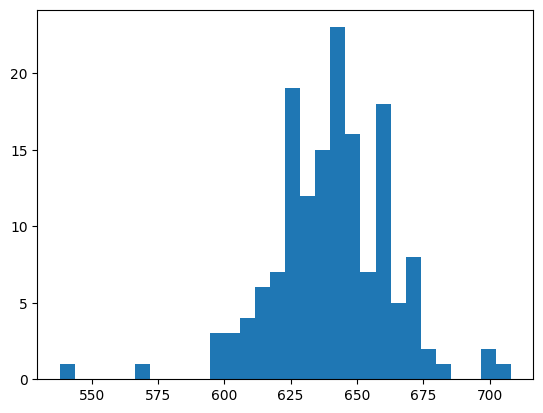

In [8]:
sonnets = text.split('\n\n')[::2]
sonnets.sort(key=lambda x: len(x), reverse=True)
lenghts = [len(s) for s in sonnets]

sonnets = [s.ljust(max(lenghts), '_') for s in sonnets]

_, _, _ = plt.hist(lenghts, bins=30)

In [9]:
def one_hot_encode(data_idx, num_tokens):
    encoded = np.zeros((len(data_idx), num_tokens))
    encoded[np.arange(len(data_idx)), data_idx] = 1.
    return encoded

In [10]:
sonnets_idx = [one_hot_encode(np.array([token_to_idx[s] for s in sonnet]), num_tokens)[None, :] for sonnet in sonnets]
dataset = np.vstack(sonnets_idx)
dataset = torch.from_numpy(dataset).to(dtype=torch.float32, device=device)
dataset.shape

torch.Size([154, 708, 39])

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [32]:
# Your code here
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam

In [50]:
class dumbRNN(nn.Module):
    def __init__(self, num_tokens, hidden_size) -> None:
        super(self.__class__,self).__init__()
        #self.emb = I won't use nn.Embedding since there are only 38 unique tokens here (-> stick to one hot encode as suggested)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(num_tokens, hidden_size, batch_first=True)
        self.hid_to_logits = nn.Linear(in_features=hidden_size, out_features=num_tokens)

    def forward(self, x):
        h_t, h_next = self.rnn(x)
        logits_all = self.hid_to_logits(h_t)
        return logits_all

In [51]:
model = dumbRNN(num_tokens=num_tokens, hidden_size=64).to(device=device)
opt = Adam(params=model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_idx['_'])
history = []

model

dumbRNN(
  (rnn): RNN(39, 64, batch_first=True)
  (hid_to_logits): Linear(in_features=64, out_features=39, bias=True)
)

In [52]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

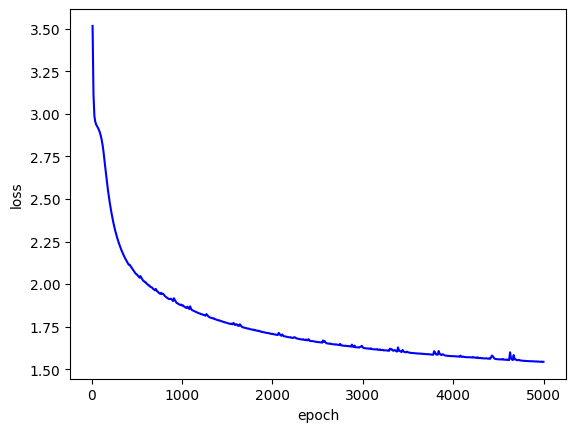

In [53]:
num_epochs = 5000

ep = []
for i in range(num_epochs):
    logits_pred = model(dataset)

    logits_next = logits_pred[:, :-1]
    actual_next_tokens = dataset[:, 1:].cpu().numpy()
    actual_next_tokens = torch.from_numpy((actual_next_tokens * np.arange(num_tokens)).sum(axis=-1)).to(dtype=torch.int64, device=device)
                                    
    loss = loss_func(logits_next.reshape(-1, num_tokens), actual_next_tokens.reshape(-1))
    loss.backward()
    
    opt.step()
    opt.zero_grad()

    if (i+1)%10==0:
        ep.append(i)
        history.append(loss.cpu().data.numpy())
        clear_output(True)
        plt.plot(ep, history, color='blue')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [54]:
# Your plot code here

# It is above

In [192]:
def generate_sample(rnn, seed_phrase='hello ', max_length=10, temperature=1.0, mode='rnn'):

    model = rnn.to(device='cpu')
    
    seed_phrase_idx = [token_to_idx[s] for s in seed_phrase]
    x_sequence = one_hot_encode(seed_phrase_idx, num_tokens)
    x_sequence = torch.from_numpy(x_sequence).to(dtype=torch.float32)
    
    h_t, h_next = model.rnn(x_sequence)

    for _ in range(max_length - len(seed_phrase_idx)):
        h_t, h_next = model.rnn(x_sequence, h_next) # DONT USE h_next ?!
        if mode=='rnn':
            logits = model.hid_to_logits(h_next)
        elif mode=='lstm':
            logits = model.hid_to_logits(h_next[0])
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]
        
        next_ix = [np.random.choice(num_tokens, p=p_next)]
        next_ix = torch.from_numpy(one_hot_encode(next_ix, num_tokens=num_tokens)).to(dtype=torch.float32)

        x_sequence = torch.cat([x_sequence, next_ix], dim=0)

    generated = (x_sequence*torch.arange(x_sequence.shape[-1])).sum(dim=1).numpy()
    generated = [idx_to_token[i] for i in generated]

    return ''.join(generated)

In [56]:
print(generate_sample(rnn=model, seed_phrase='hello ', temperature=1., max_length=500, mode='rnn'))

hello trow,
  then thee he cair's soobs blace will dy measure
  you my berove all muin unkelts'd,
  where the like in to gooknes tine;
  hanggncaning in and then bagting even thee of tire,
    ant thou war becances to jey trow dear'd thee:
  for a soply, hoth to that make in titht shall-will:
  you seem forthing, i so deedis fixtomnd divis reace.
  not should passe the allsed, who drest, do fied fell toms ware,
  and not mo them from thy in thee,
  and ither so thee as ven. look it thing,
  by o


**Looks very sussy with trashy model, but it's OK**

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [59]:
# Your beautiful code here

class basicLSTM(nn.Module):
    def __init__(self, num_tokens, hidden_size) -> None:
        super(self.__class__,self).__init__()
        #self.emb = I won't use nn.Embedding since there are only 38 unique tokens here (-> stick to one hot encode as suggested)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(num_tokens, hidden_size, batch_first=True)
        self.hid_to_logits = nn.Linear(in_features=hidden_size, out_features=num_tokens)

    def forward(self, x):
        h_t, h_next = self.rnn(x)
        logits_all = self.hid_to_logits(h_t)
        return logits_all

In [60]:
model = basicLSTM(num_tokens=num_tokens, hidden_size=64).to(device=device)
opt = Adam(params=model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_idx['_'])
history = []

model

basicLSTM(
  (rnn): LSTM(39, 64, batch_first=True)
  (hid_to_logits): Linear(in_features=64, out_features=39, bias=True)
)

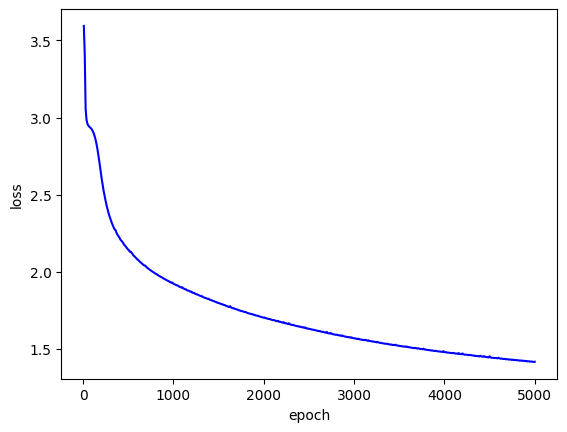

In [61]:
num_epochs = 5000

ep = []
for i in range(num_epochs):
    logits_pred = model(dataset)

    logits_next = logits_pred[:, :-1]
    actual_next_tokens = dataset[:, 1:].cpu().numpy()
    actual_next_tokens = torch.from_numpy((actual_next_tokens * np.arange(num_tokens)).sum(axis=-1)).to(dtype=torch.int64, device=device)
                                    
    loss = loss_func(logits_next.reshape(-1, num_tokens), actual_next_tokens.reshape(-1))
    loss.backward()
    
    opt.step()
    opt.zero_grad()

    if (i+1)%10==0:
        ep.append(i)
        history.append(loss.cpu().data.numpy())
        clear_output(True)
        plt.plot(ep, history, color='blue')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [47]:
# Text generation with different temperature values here

**T=0.1**

In [62]:
print(generate_sample(rnn=model, seed_phrase='hello ', temperature=0.1, max_length=500, mode='lstm'))

hello kness of heart,
  and the self all the world of the worth thee,
    and the self the worth the stends of the me,
  the world of the theer shall the strange,
  the world the stare with the worth the strangly spends,
  they change the stends of the worth the strange,
  the self i am the world of the strange,
  the self i am all the world do not so,
    and the world with the world of the worth thee,
    and the beauty with the world of thee,
  and the self the their shall the stain,
    and 


**T=0.2**

In [63]:
print(generate_sample(rnn=model, seed_phrase='hello ', temperature=0.2, max_length=500, mode='lstm'))

hello kness of theerir,
  or and the strange the self more to me me,
    and the world that the true love to thee,
  and the more that i love the stenk to shen,
    the self i as the see doth distross,
  and the self in the summer's love thee,
    the surment the worth the worth the store,
  and thee the sweet so love the worth thee,
    the self the self the more to my strange,
  and the truth in the world with the stare so due,
  and that the world of the some shall be thee,
    the self i am 


**T=0.5**

In [64]:
print(generate_sample(rnn=model, seed_phrase='hello ', temperature=0.5, max_length=500, mode='lstm'))

hello st steet,
  and some is thy same then the me that with thee,
  when i and his with then whose subsing care,
  and piel' all the the have shall be is fair,
    to fair have sweet i world of the stend
  which in the worth beauty all the me,
  so loss hath worths more there as thy me's,
  that the see the see one substieve thee,
    and see the theer my love the warth to thee.
    yet thee to purpain thee world so read you not,
  on thines make the sun thee will of thee so;
  when the seem an


**T=1**

In [65]:
print(generate_sample(rnn=model, seed_phrase='hello ', temperature=1., max_length=500, mode='lstm'))

hello doin attaint the cay poor, sqofecter not brign suncels foul severy,
  as for this beauty tose wounk all tho neave:
  anting thou breast me, thou wared ploss?
  and trust all take a, hote i lote in tiew
  for thnsharing sharthing mathon have in right,
  ot to the kink, ald heate that clacks ot,
  wherefore wretting returing cocroad,
  the givet withies make fill amoking me:
  those live therers worling itair have them.
    as the that for shame him a saym'd not place:
    sore, nor iffut co


**T=2**

In [66]:
print(generate_sample(rnn=model, seed_phrase='hello ', temperature=2., max_length=500, mode='lstm'))

hello engise!
  no,,
  aflsharing eshopct'r's of'th rwinc
 , disuary oncfiler's weil knay'st:_h
  my, jmes (tchugh: 
 earist; offnive he lot.
  iver-roo werelvhnoice's frook;
  dy raautuak wamght, jout(trife,
  sum mykanklest sce mokisb pryenso, nudg',
  to eves timbix at evid my fliem
  ;u butted, pumpst noth' cast no progiln,
  witct gived,' gy shettr'sr cuble porrow'd faves do;
  khn lostle hopom'r, xic de'st impret;
  floul onn sowons; beaids's dic'eces fer trias:
  ujekinc otheal sweet acir


**My answer: the higher the temperature the closer probability ditribution over the DICT to uniform. Basically there is not point in generation with high temperatue since 1) u generate garbage; 2) it make no sense to train some model for it**

### I will also try out dictionary of words and punctuation marks (not letters)

Here DICT will consist of punctuation marks and words. I'll also use `nn.Embedding` instead of just `one_hot` representation

In [309]:
import re

In [310]:
sonnets = text.split('\n\n')[::2]

In [285]:
sonnets_splitted = [re.sub(r'[?!@#%\^&\*\(\):;"\',\./\\\-\+|\n]', r' \g<0> ', sonnet).strip() for sonnet in sonnets]
sonnets_splitted = [re.split(pattern=' ', string=sonnet) for sonnet in sonnets_splitted]
sonnets_splitted = [[s for s in sonnet if s!=''] for sonnet in sonnets_splitted]

In [287]:
sonnets_splitted[0].count('\n')

13

In [288]:
print(' '.join(sonnets_splitted[0]))

from fairest creatures we desire increase , 
 that thereby beauty ' s rose might never die , 
 but as the riper should by time decease , 
 his tender heir might bear his memory : 
 but thou , contracted to thine own bright eyes , 
 feed ' st thy light ' s flame with self - substantial fuel , 
 making a famine where abundance lies , 
 thy self thy foe , to thy sweet self too cruel : 
 thou that art now the world ' s fresh ornament , 
 and only herald to the gaudy spring , 
 within thine own bud buriest thy content , 
 and tender churl mak ' st waste in niggarding : 
 pity the world , or else this glutton be , 
 to eat the world ' s due , by the grave and thee .


In [289]:
print(sonnets[0])

  from fairest creatures we desire increase,
  that thereby beauty's rose might never die,
  but as the riper should by time decease,
  his tender heir might bear his memory:
  but thou, contracted to thine own bright eyes,
  feed'st thy light's flame with self-substantial fuel,
  making a famine where abundance lies,
  thy self thy foe, to thy sweet self too cruel:
  thou that art now the world's fresh ornament,
  and only herald to the gaudy spring,
  within thine own bud buriest thy content,
  and tender churl mak'st waste in niggarding:
    pity the world, or else this glutton be,
    to eat the world's due, by the grave and thee.


In [311]:
dictionary = set()

sonnets_splitted = [re.sub(r'[?!@#%\^&\*\(\):;"\',\./\\\-\+|\n]', r' \g<0> ', sonnet).strip() for sonnet in sonnets]
sonnets_splitted = [re.split(pattern=' ', string=sonnet) for sonnet in sonnets_splitted]
sonnets_splitted = [[s for s in sonnet if s!=''] for sonnet in sonnets_splitted]
sonnets_splitted.sort(key=lambda x: len(x), reverse=True)
for s in sonnets_splitted:
    dictionary = dictionary.union(set(s))

dictionary.add('_') # fake token
dictionary = sorted(dictionary)

len(dictionary), dictionary

(3063,
 ['\n',
  '!',
  "'",
  '(',
  ')',
  ',',
  '-',
  '.',
  ':',
  ';',
  '?',
  '_',
  'a',
  'abhor',
  'abide',
  'able',
  'about',
  'above',
  'absence',
  'absent',
  'abundance',
  'abundant',
  'abus',
  'abuse',
  'abuses',
  'abysm',
  'accents',
  'acceptable',
  'acceptance',
  'accessary',
  'accident',
  'accidents',
  'account',
  'accumulate',
  'accuse',
  'accusing',
  'achieve',
  'acknowledge',
  'acquaintance',
  'acquainted',
  'act',
  'action',
  'active',
  'actor',
  'add',
  'added',
  'adder',
  'addeth',
  'adding',
  'addition',
  'adieu',
  'adjunct',
  'admire',
  'admired',
  'admiring',
  'admit',
  'admitted',
  'adonis',
  'adore',
  'adulterate',
  'advance',
  'advantage',
  'adverse',
  'advis',
  'advocate',
  'afar',
  'affable',
  'affairs',
  'affections',
  'afford',
  'affords',
  'afloat',
  'afresh',
  'after',
  'afterwards',
  'again',
  'against',
  'age',
  'ages',
  'aggravate',
  'ah',
  'aid',
  'air',
  'alack',
  'alas',
  

In [312]:
dictionary[' ']

TypeError: list indices must be integers or slices, not str

Total number of advanced tokens in all sonnets is 23798
Average frequency of a single token is 7
Max length of a sonnet is 174


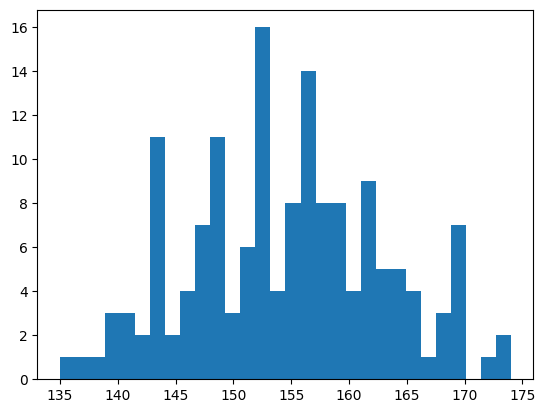

In [313]:
lengths_splitted = [len(s) for s in sonnets_splitted]

_,_,_ = plt.hist(lengths_splitted, bins=30)
print(f'Total number of advanced tokens in all sonnets is {sum(lengths_splitted)}')
print(f'Average frequency of a single token is {int(sum(lengths_splitted)/len(dictionary))}')
print(f'Max length of a sonnet is {max(lengths_splitted)}')

Word of maximal lenght consists of 14 letters
Word of minimal lenght consists of 1 letter
Average lenght of a word is 6 letters


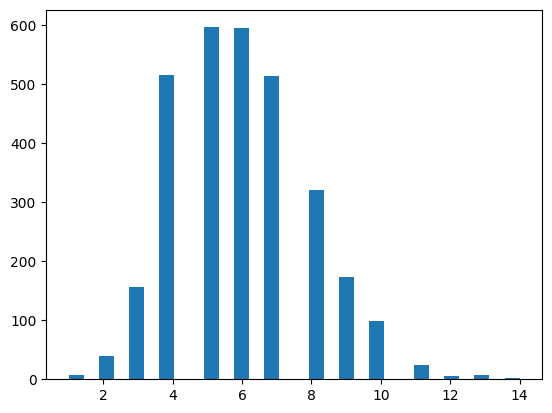

In [314]:
length_words = [len(word) for word in dictionary[12:]]

_,_,_ = plt.hist(length_words, bins=30)

print(f'Word of maximal lenght consists of {max(length_words)} letters')
print(f'Word of minimal lenght consists of {min(length_words)} letter')
print(f'Average lenght of a word is {round(np.mean(length_words))} letters')

Pad all sonnets:

In [315]:
def pad_list(some_list, target_len):
    return some_list[:target_len] + ['_']*(target_len - len(some_list))

In [316]:
len(sonnets_splitted[10]), max(lengths_splitted)

(168, 174)

In [317]:
sonnets_splitted = [pad_list(sonnet, max(lengths_splitted)) for sonnet in sonnets_splitted]

Token to id and vice versa again:

In [318]:
token_to_id = {token: i for i, token in enumerate(dictionary)}
id_to_token = {i: token for i, token in enumerate(dictionary)}
token_to_id['_'], idx_to_token[11]

(11, '_')

In [319]:
sonnets_encoded = np.array([[token_to_id[token] for token in sonnet] for sonnet in sonnets_splitted])
sonnets_encoded.shape

(154, 174)

In [320]:
int(len(dictionary)/(int(sum(lengths_splitted)/len(dictionary))-4))

1021

Let's try `embedding_size` of `int(len(dictionary)/(int(sum(lengths_splitted)/len(dictionary))-const))`. I'll take smth like `~1024`

In [325]:
class betterLSTM(nn.Module):
    def __init__(self, num_tokens=len(dictionary), embedding_size=2**10, hidden_size=2**7) -> None:
        super(self.__class__,self).__init__()
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(num_embeddings=num_tokens, embedding_dim=embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, batch_first=True, num_layers=1)
        self.hid_to_logits = nn.Linear(in_features=hidden_size, out_features=num_tokens)

    def forward(self, x):
        x_emb = self.emb(x)
        h_t, h_next = self.rnn(x_emb)
        logits_all = self.hid_to_logits(h_t)
        return logits_all

In [326]:
model = betterLSTM().to(device=device)
opt = Adam(params=model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_id['_'])
history = []

model

betterLSTM(
  (emb): Embedding(3063, 1024)
  (rnn): LSTM(1024, 128, batch_first=True)
  (hid_to_logits): Linear(in_features=128, out_features=3063, bias=True)
)

In [327]:
sonnets_encoded = torch.from_numpy(sonnets_encoded).to(dtype=torch.int64, device=device)
sonnets_encoded.shape

TypeError: expected np.ndarray (got Tensor)

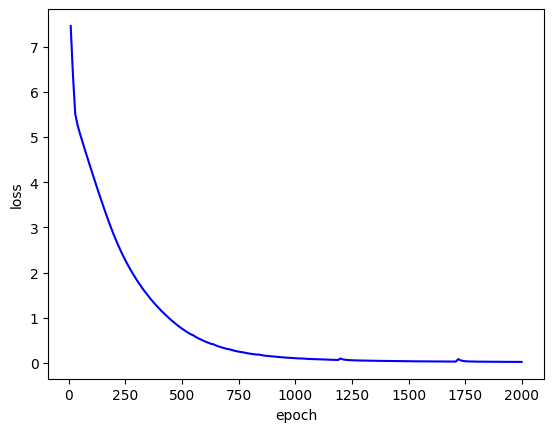

In [328]:
num_epochs = 2000

ep = []
for i in range(num_epochs):
    logits_pred = model(sonnets_encoded)

    logits_next = logits_pred[:, :-1]
    actual_next_tokens = sonnets_encoded[:, 1:]
                                    
    loss = loss_func(logits_next.reshape(-1, len(dictionary)), actual_next_tokens.reshape(-1))
    loss.backward()
    
    opt.step()
    opt.zero_grad()

    if (i+1)%10==0:
        ep.append(i)
        history.append(loss.cpu().data.numpy())
        clear_output(True)
        plt.plot(ep, history, color='blue')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()

In [329]:
def generate_cool_poem(rnn, seed_phrase=['i', 'was', 'able'], max_length=10, temperature=1.0):

    model = rnn.to(device='cpu')
    
    x_sequence = np.array([token_to_id[s] for s in seed_phrase])
    x_sequence = torch.from_numpy(x_sequence).to(dtype=torch.int64)

    for _ in range(max_length - len(seed_phrase)):
        x_sequence_emb = model.emb(x_sequence)
        h_t, h_next = model.rnn(x_sequence_emb)
        logits = model.hid_to_logits(h_next[0])
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]
        
        next_ix = torch.tensor([np.random.choice(len(dictionary), p=p_next)]).to(dtype=torch.int64)

        x_sequence = torch.cat([x_sequence, next_ix], dim=0)

    generated = [id_to_token[i] for i in x_sequence.numpy()]

    return ' '.join(generated)

In [330]:
token_to_id['i'], token_to_id['was'], token_to_id['able']

(1330, 2891, 15)

In [338]:
print(generate_cool_poem(model, seed_phrase=['i', 'was', 'able'], max_length=100, temperature=0.5))

i was able spirit in other accents do this dull my muse , and this i not that i am old ? 
 my love , then thou hast the strength of all thy state ! 
 but that , the very same thy 
 and do in thy end ; 
 and in my sake even to be . 
 i love thee to say , as all she with you , you your beauty , 
 and i must be most my heart to sway ? 
 to make me give the lie to thy large let my


Smth like dat. I was lazy to fix the thing with commas and other punctuation marks. It also better to use some package to work with text rather than do everyting from scratch.

Obviously to get meaningfull results you have to use more data or even pretrained LLM and then fine-tune it. In <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> more complex structure of RNN was used and the dataset was about `4.4MB` compared to `120Kb` in this educational task. 

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [342]:
opt.state_dict().keys()

dict_keys(['state', 'param_groups'])

In [343]:
# Saving and loading code here

def save_checkpoint(model, optimizer, epoch, loss, filename='./checkpoint.pt'):
    torch.save(
        {
            'epoch': epoch,
            'loss': loss,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        },
        filename,
    )

def load_checkpoint(model, optimizer, path_to_checkpoint='./checkpoint.pt', le=True):
    checkpoint = torch.load(path_to_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer!=None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if le:
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        return epoch, loss

In [345]:
save_checkpoint(model, opt, i, history[-1])

In [346]:
model_from_checkpoint = betterLSTM().to(device=device)
load_checkpoint(model_from_checkpoint, optimizer=None)

(1999, array(0.02124331, dtype=float32))

In [348]:
model_from_checkpoint

betterLSTM(
  (emb): Embedding(3063, 1024)
  (rnn): LSTM(1024, 128, batch_first=True)
  (hid_to_logits): Linear(in_features=128, out_features=3063, bias=True)
)

In [349]:
print(generate_cool_poem(model_from_checkpoint, seed_phrase=['i', 'was', 'able'], max_length=100, temperature=0.5))

i was able spirit in other my mistress ' eyes , 
 when in thy beauty ' s form form of heart to dead ; 
 but from his love , and i to be new ' d ; 
 for all were , if it bore not beauty ' s name ; 
 but now is black beauty ' s successive heir , 
 and beauty slander ' d with a bastard shame : 
 for since each hand hath put on nature ' s power , 
 fairing the foul with art ' s false borrowed face ,


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)